- Increased max token length from 256 → 512 to reduce information loss.
- Switched to softer text cleaning to preserve punctuation and technical terms. 
- 52% of abstracts are larger than 256 tokens, after softer cleaning. Before it was around 32%.

Result: Almost every unlabeled abstract is predicted supervised.

## Setup

In [1]:
# Imports

import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from tqdm import tqdm
import collections

In [2]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
table_path = Path("../../reports/tables")
figure_path = Path("../../reports/figures")
keywords_path = Path("../../keywords")
processed_abstracts_path = Path("../../data/processed/abstracts")

# Ensure directories exist
for p in [data_path, table_path, figure_path, keywords_path, processed_abstracts_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")


All directories verified/created.


In [3]:
# Constants

CREATE_ABSTRACTS_DATASET = True

# Number of topics used for K-means
n_topics = 8

#### Create Abstracts dataset (only need to do this once)

In [4]:
# Helper: Clean Abstracts
# Basic text cleaning

# Light cleaning for model input: keep most of the original signal
def clean_text_for_model(text):
    if not isinstance(text, str):
        return ""

    # Remove copyright statements at the beginning of the abstract
    text = re.sub(r"^©[^\.\n]*\.?\s*", "", text, flags=re.IGNORECASE)

    # Optionally strip URLs and extra whitespace, but keep punctuation, numbers, etc.
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


In [5]:
records = []

if CREATE_ABSTRACTS_DATASET:

    for folder in sorted(data_path.iterdir()):
        if not folder.is_dir():
            continue
        query_id = folder.name
        jsonl_files = list(folder.glob("*.jsonl"))
        for fp in jsonl_files:
            with fp.open("r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        rec = json.loads(line)
                    except json.JSONDecodeError:
                        continue

                    abs_txt = rec.get("abstract") or rec.get("description") or ""
                    if isinstance(abs_txt, list):
                        abs_txt = " ".join(str(x) for x in abs_txt if x)

                    # Cover date was not included in last script
                    records.append({
                        "query_id": query_id,
                        "eid": rec.get("eid"),
                        "doi": rec.get("doi"),
                        "title": rec.get("title"),
                        # "coverDate": rec.get("coverDate"),
                        "abstract": abs_txt.strip()
                    })

    df = pd.DataFrame(records)
    
    # Remove empty abstracts early
    df = df[df["abstract"].notna() & (df["abstract"].str.strip() != "")]
    df = df.reset_index(drop=True)
    
    # Clean abstracts
    df["clean_abs"] = df["abstract"].apply(clean_text_for_model)
    
    print(f"\nCollected {len(df)} abstracts from {len(df['query_id'].unique())} queries")

    # Save for later analysis
    out_path = processed_abstracts_path / "abstracts.csv"
    df.to_csv(out_path, index=False)
    print(f"Saved: {out_path}")



Collected 52290 abstracts from 24 queries
Saved: ../../data/processed/abstracts/abstracts.csv


In [6]:
# Load dataframe with abstracts
# Only if it has been created earlier

if not CREATE_ABSTRACTS_DATASET:
    abstracts_path = processed_abstracts_path / "abstracts.csv"
    df = pd.read_csv(abstracts_path) 
    print(f"Loaded {len(df)} abstracts")


In [ ]:
df["doi"].duplicated().sum()

In [ ]:
duplicate_dois = df[df["doi"].duplicated(keep=False)].sort_values("doi")
duplicate_dois.head()


In [ ]:
# Count how many rows each query_id has
query_counts = df["query_id"].value_counts().to_dict()

# Create a copy and map the counts to each row
df = df.copy()
df["query_size"] = df["query_id"].map(query_counts)

# Sort so that query groups with fewer rows are prioritized
df_sorted = df.sort_values(by="query_size", ascending=True)

# Remove duplicate DOIs, keeping the one in the smallest query group
df_dedup = df_sorted.drop_duplicates(subset="doi", keep="first").drop(columns=["query_size"])

# Print results
print("Original dataset size:", len(df))
print("After removing duplicates:", len(df_dedup))
print("Remaining duplicate DOIs:", df_dedup["doi"].duplicated().sum())

df = df_dedup

In [7]:
df.head(10)

,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,"Indeed, highly efficient systems do not always..."
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",The detection and localization of quality-rela...
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...","In modern Industry, I4.0, artificial intellige..."
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,The critical necessity for sophisticated predi...
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,"Hence, detecting any anomaly concerning BGP an..."
5,ml_anomaly_detection_production,2-s2.0-105017424887,10.1016/j.rineng.2025.107446,Explainable artificial intelligence framework ...,© 2025 The Author(s)Though wind energy has gre...,Although installed wind capacity exceeds 51. 3...
6,ml_anomaly_detection_production,2-s2.0-105014634588,10.1186/s42162-025-00565-x,Towards privacy-preserving anomaly-based intru...,© The Author(s) 2025.Energy communities consis...,Energy communities consist of decentralized en...
7,ml_anomaly_detection_production,2-s2.0-105014606463,10.1038/s41597-025-05858-0,A Dataset of Univariate Crimp Force Curves for...,© The Author(s) 2025.Data availability represe...,Data availability represents a critical bottle...
8,ml_anomaly_detection_production,2-s2.0-105014604682,10.1038/s41598-025-16276-y,Flame monitoring and anomaly detection in stee...,© The Author(s) 2025.Reheating furnaces are es...,Reheating furnaces are essential in steel manu...
9,ml_anomaly_detection_production,2-s2.0-105010747422,10.1038/s41598-025-07550-0,Hyperbolic geometry enhanced feature filtering...,"© The Author(s) 2025.In recent years, Cutting-...","In recent years, Cutting-edge machine learning..."


## Analyze with Keywords (Supervised / Unsupervised / Reinforcement)

Each article is classified using keyword matching based on its cleaned abstract.
The classification is **multi-label**, meaning an article may be tagged as
supervised, unsupervised, and/or reinforcement learning depending on which
keywords appear as whole words in the text.

In [13]:
# Gather all keywords 

def load_keyword_file(path: Path) -> list[str]:
    keywords = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            keywords.append(line.lower())
    return keywords


def load_all_keywords(base_dir: Path = keywords_path) -> dict[str, list[str]]:
    return {
        "supervised": load_keyword_file(base_dir / "supervised.txt"),
        "unsupervised": load_keyword_file(base_dir / "unsupervised.txt"),
        "reinforcement": load_keyword_file(base_dir / "reinforcement.txt"),
    }


ml_keywords = load_all_keywords()


In [14]:
# For each ML category, create a binary column (1/0) indicating
# whether any of that category's keywords appear in the cleaned abstract.
# (Uses word-boundary matching so e.g. 'supervised' does NOT match inside 'unsupervised')

def contains_keyword(text, keyword):
    # Escape keyword and enforce word boundaries (\b)
    pattern = rf"\b{re.escape(keyword)}\b"
    return re.search(pattern, text) is not None

for label in ml_keywords.keys():
    df[f"is_{label}"] = df["clean_abs"].apply(
        lambda t, lab=label: any(contains_keyword(str(t).lower(), w) for w in ml_keywords[lab])

    )
    
df.head(2)

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,"Indeed, highly efficient systems do not always...",True,True,False
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",The detection and localization of quality-rela...,True,True,False


In [15]:
# Create a column: "ml_type" that lists all categorys with True

def resolve_label(row):
    labels = []
    if row["is_supervised"]: labels.append("supervised")
    if row["is_unsupervised"]: labels.append("unsupervised")
    if row["is_reinforcement"]: labels.append("reinforcement")
    return labels or ["unknown"]

df["ml_type"] = df.apply(resolve_label, axis=1)

df.head()


,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,"Indeed, highly efficient systems do not always...",True,True,False,"[supervised, unsupervised]"
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",The detection and localization of quality-rela...,True,True,False,"[supervised, unsupervised]"
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...","In modern Industry, I4.0, artificial intellige...",True,True,False,"[supervised, unsupervised]"
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,The critical necessity for sophisticated predi...,True,True,False,"[supervised, unsupervised]"
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,"Hence, detecting any anomaly concerning BGP an...",False,True,False,[unsupervised]


In [16]:
# Frequency of each ML category
df["ml_type"].explode().value_counts()

ml_type
unknown          30552
supervised       16216
unsupervised      5885
reinforcement     3207
Name: count, dtype: int64

In [17]:
# Frequency for each query
df.explode("ml_type").groupby(["query_id", "ml_type"]).size().unstack(fill_value=0)

ml_type,reinforcement,supervised,unknown,unsupervised
query_id,,,,
ml_anomaly_detection_production,30,292,73,590
ml_automation,126,321,1138,150
ml_defect_detection,23,297,323,121
ml_disassembly,31,107,189,34
ml_end_of_life,9,13,28,3
ml_inservice_monitoring,60,318,491,108
ml_manufacturing,917,5246,10166,1714
ml_manufacturing_optimization,330,1105,2400,307
ml_planning_production,250,784,1220,198


In [18]:
# Percentage of abstracts that mention each ML category
df[["is_supervised", "is_unsupervised", "is_reinforcement"]].mean()

is_supervised       0.310117
is_unsupervised     0.112545
is_reinforcement    0.061331
dtype: float64

<Axes: xlabel='ml_type'>

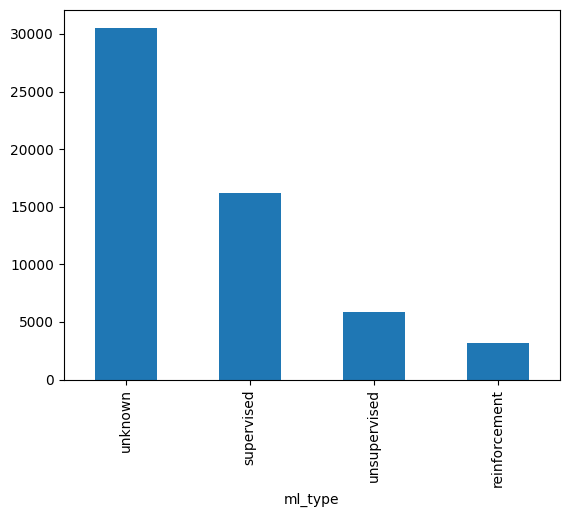

In [19]:
# Plot frequency of ML categories across all abstracts
df["ml_type"].explode().value_counts().plot(kind="bar")

In [20]:
# Sample of abstracts that were classified as "unknown"
# Should analyze to improve keyword sets
df[df["ml_type"].apply(lambda x: x == ["unknown"])].sample(2)


,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type
12948,ml_manufacturing,2-s2.0-85149932825,10.1016/j.engappai.2023.105988,The role of artificial intelligence-driven sof...,© 2023 The Author(s)With the predicted depleti...,"Hence, manufacturers are quite keen on adoptin...",False,False,False,[unknown]
34709,ml_process_control,2-s2.0-85105591239,10.1016/j.ifacol.2020.11.034,Development of an augmented reality equipped c...,Copyright © 2020 The Authors. This is an open ...,Copyright © 2020 The Authors. This is an open ...,False,False,False,[unknown]


### Check most common ML method (most common keyword)



In [21]:
# all_text = " ".join(df["clean_abs"])

# method_counts = collections.Counter()

# for label, words in ml_keywords.items():
#     for w in words:
#         # Regex: match keyword as a whole word, case-insensitive
#         pattern = rf"\b{re.escape(w)}\b"
#         count = df["clean_abs"].str.contains(pattern, regex=True, case=False).sum()
#         method_counts[w] = count

# method_counts.most_common(20)

### Notes on Keyword-Based Classification

The keyword approach provides a simple first pass, but it has clear limitations:
- Many abstracts are labeled **unknown** because keywords may be absent, implicit, or expressed differently.
- Some methods overlap terminology (e.g., “semi-supervised”), which can lead to misclassification.
- Context is ignored, so the presence of a term does not guarantee it is the main ML method.

These limitations explain the large number of “unknown” cases and motivate using a more robust model-based classifier later.

## Training a Multi-Label ML-Method Classifier Using Keyword Pseudo-Labels

- The keyword-based approach provides noisy but useful initial labels for each article (e.g., supervised / unsupervised / reinforcement).  
- In the following steps, we use these pseudo-labels to train a **multi-label transformer model** (e.g., SciBERT or DistilBERT) on the abstracts. 
- This allows the model to learn richer linguistic patterns and produce more accurate classifications than the raw keyword method, while requiring **no manual labeling up front**.


In [22]:
import torch
print(torch.__version__)

2.9.1+cu128


In [23]:
from datasets import Dataset
import numpy as np

label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Keep only rows that have at least one positive label (optional but often useful)
df_model = df.copy()
mask_any_label = df_model[label_cols].sum(axis=1) > 0
df_model = df_model[mask_any_label].reset_index(drop=True)

print(df_model[label_cols].mean())  # quick check of label frequencies

dataset = Dataset.from_pandas(df_model[["clean_abs"] + label_cols])

# Train/validation split
splits = dataset.train_test_split(test_size=0.2, seed=42)
train_ds = splits["train"]
val_ds = splits["test"]



/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


is_supervised       0.745975
is_unsupervised     0.270724
is_reinforcement    0.147530
dtype: float64


In [24]:
# Ensure scibert directory exists
scibert_path = processed_abstracts_path / "scibert_2"
scibert_path.mkdir(parents=True, exist_ok=True)

# Save datasets
train_path = scibert_path / "train_ds.csv"
val_path = scibert_path / "val_ds.csv"

train_ds.to_csv(train_path, index=False)
val_ds.to_csv(val_path, index=False)

print(f"Saved train_ds to: {train_path}")
print(f"Saved val_ds to:   {val_path}")

Creating CSV from Arrow format: 100%|██████████| 5/5 [00:00<00:00, 31.99ba/s]

Saved train_ds to: ../../data/processed/abstracts/scibert_2/train_ds.csv
Saved val_ds to:   ../../data/processed/abstracts/scibert_2/val_ds.csv


In [25]:
train_ds.to_pandas().head()


,clean_abs,is_supervised,is_unsupervised,is_reinforcement
0,These collectors are constructed in accordance...,True,False,False
1,The global goal of achieving 2000 gigawatts of...,True,False,False
2,"Licensee MDPI, Basel, Switzerland.The Semantic...",True,False,False
3,As the Internet of Things technology is develo...,False,True,False
4,The significance of this paper is an investiga...,True,False,False


In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "allenai/scibert_scivocab_uncased"  # or "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Add a single multi-label 'labels' column
def add_labels(example):
    example["labels"] = [float(example[c]) for c in label_cols]
    return example

train_ds_l = train_ds.map(add_labels)
val_ds_l   = val_ds.map(add_labels)

def tokenize_batch(batch):
    return tokenizer(
        batch["clean_abs"],
        padding="max_length",
        truncation=True,
        max_length=512,
    )

train_ds_tok = train_ds_l.map(tokenize_batch, batched=True)
val_ds_tok   = val_ds_l.map(tokenize_batch, batched=True)

def set_format(ds):
    return ds.with_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels"],
    )

train_ds_tok = set_format(train_ds_tok)
val_ds_tok   = set_format(val_ds_tok)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_cols),
    problem_type="multi_label_classification",
)


Map: 100%|██████████| 4348/4348 [00:01<00:00, 3282.68 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Compute average number of tokens per abstract using the tokenizer

lengths = []

for text in df["clean_abs"].tolist():
    enc = tokenizer(
        text,
        truncation=True,
        max_length=2048,
    )
    lengths.append(len(enc["input_ids"]))

avg_len = sum(lengths) / len(lengths)
max_len = max(lengths)
min_len = min(lengths)

print(f"Average token length: {avg_len:.2f}")
print(f"Min tokens: {min_len}, Max tokens: {max_len}")


Average token length: 260.85
Min tokens: 2, Max tokens: 2048


In [28]:
# Count how many abstracts exceed various token-length thresholds

thresholds = [256, 512, 768, 1024, 1500]

lengths = []
for text in df["clean_abs"].tolist():
    enc = tokenizer(text, truncation=False)   # do NOT truncate → get true length
    lengths.append(len(enc["input_ids"]))

results = {}
for t in thresholds:
    results[t] = sum(l > t for l in lengths)

print("Token length distribution:")
for t, count in results.items():
    print(f" > {t:4d} tokens : {count} abstracts")

# Optional: also show % of dataset
n = len(lengths)
print("\nPercentages:")
for t, count in results.items():
    print(f" > {t:4d} tokens : {count/n*100:.2f}%")


Token length distribution:
 >  256 tokens : 23550 abstracts
 >  512 tokens : 1129 abstracts
 >  768 tokens : 255 abstracts
 > 1024 tokens : 113 abstracts
 > 1500 tokens : 9 abstracts

Percentages:
 >  256 tokens : 45.04%
 >  512 tokens : 2.16%
 >  768 tokens : 0.49%
 > 1024 tokens : 0.22%
 > 1500 tokens : 0.02%


In [29]:
# Check cuda version etc for debugging

print(torch.version.cuda)
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())
print(torch.cuda.get_arch_list())

12.8
NVIDIA A100 80GB PCIe
(8, 0)
['sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90', 'sm_100', 'sm_120']


In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))           # sigmoid
    preds = (probs >= 0.5).astype(int)

    # Flatten over labels
    return {
        "f1_micro": f1_score(labels, preds, average="micro", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "precision_micro": precision_score(labels, preds, average="micro", zero_division=0),
        "recall_micro": recall_score(labels, preds, average="micro", zero_division=0),
    }

training_args = TrainingArguments(
    output_dir="./ml_type_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tok,
    eval_dataset=val_ds_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipykernel_1973823/310402851.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Precision Micro,Recall Micro
1,0.011900,0.015204,0.995541,0.993884,0.996232,0.994851
2,0.003600,0.011850,0.996835,0.996010,0.995654,0.998020


In [ ]:
# Tune thresholds based on validation set

logits_val, labels_val = trainer.predict(val_ds_tok)[:2]
probs_val = 1 / (1 + np.exp(-logits_val))

best_thresholds = {}

for i, col in enumerate(label_cols):
    best_f1 = 0.0
    best_t = 0.5
    for t in np.linspace(0.1, 0.9, 17):  # Try thresholds between 0.1 and 0.9
        preds = (probs_val[:, i] >= t).astype(int)
        f1 = f1_score(labels_val[:, i], preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds[col] = best_t

print("Best thresholds:", best_thresholds)


Best thresholds: {'is_supervised': np.float64(0.35), 'is_unsupervised': np.float64(0.55), 'is_reinforcement': np.float64(0.1)}


In [ ]:
def predict_ml_types_batched(texts, trainer, threshold=0.5, batch_size=64, max_length=512):
    all_preds = []
    all_probs = []

    model = trainer.model
    model.eval()

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        enc = {k: v.to(model.device) for k, v in enc.items()}

        with torch.no_grad():
            logits = model(**enc).logits

        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= threshold).astype(int)

        all_probs.append(probs)
        all_preds.append(preds)

    all_probs = np.vstack(all_probs)
    all_preds = np.vstack(all_preds)
    return all_preds, all_probs


texts = df["clean_abs"].tolist()
preds, probs = predict_ml_types_batched(texts, trainer, batch_size=64, threshold=0.5)

for i, col in enumerate(label_cols):
    df[f"pred_{col}"] = preds[:, i]


In [ ]:
for i, col in enumerate(label_cols):
    df[f"pred_{col}"] = preds[:, i]

pred_cols = [f"pred_{c}" for c in label_cols]
cols_to_save = [
    "query_id", "eid", "doi", "title", "abstract", "clean_abs",
] + label_cols + pred_cols

save_path = scibert_path / "abstracts_with_predictions.csv"
df[cols_to_save].to_csv(save_path, index=False)

print(f"Saved predictions to: {save_path}")

Saved predictions to: ../../data/processed/abstracts/scibert_2/abstracts_with_predictions.csv


## Analyze Scibert Predictions

In [ ]:
pred_path = Path("../../data/processed/abstracts/scibert_2/abstracts_with_predictions.csv")

pred_cols = ["pred_is_supervised","pred_is_unsupervised","pred_is_reinforcement"]

In [ ]:
df = pd.read_csv(pred_path)
df.head()

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...,True,True,False,1,1,0
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",True,True,False,1,1,0
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",True,True,False,1,1,0
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,2025.The critical necessity for sophisticated ...,True,True,False,1,1,0
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,© 2025 The AuthorsThe Border Gateway Protocol ...,False,True,False,0,1,0


In [ ]:
df[pred_cols].mean()

pred_is_supervised       0.723696
pred_is_unsupervised     0.149752
pred_is_reinforcement    0.094669
dtype: float64

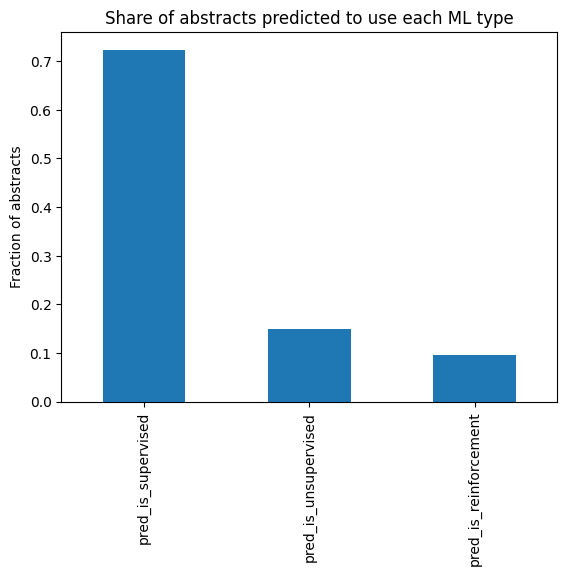

In [ ]:
df[pred_cols].mean().plot(kind="bar")
plt.title("Share of abstracts predicted to use each ML type")
plt.ylabel("Fraction of abstracts")
plt.show()

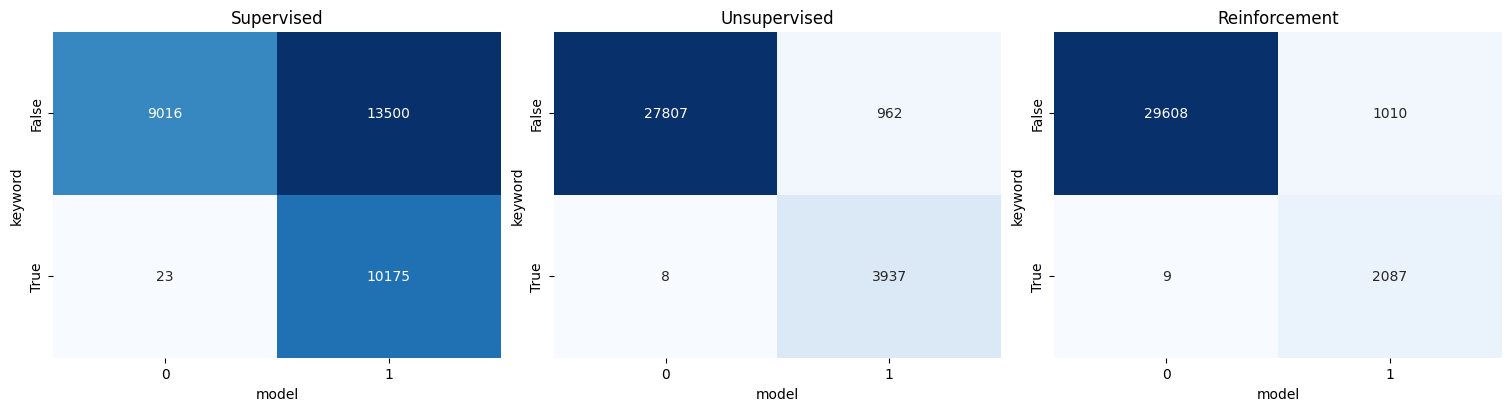

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

for ax, col in zip(axes, label_cols):
    ctab = pd.crosstab(df[col], df[f"pred_{col}"], rownames=["keyword"], colnames=["model"])
    
    sns.heatmap(
        ctab,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax
    )
    ax.set_title(col.replace("is_", "").capitalize())

plt.show()


In [ ]:
# Small per-label stats
for col in label_cols:
    pred = df[f"pred_{col}"]
    true = df[col]

    tp = ((true == 1) & (pred == 1)).sum()
    fp = ((true == 0) & (pred == 1)).sum()
    fn = ((true == 1) & (pred == 0)).sum()
    tn = ((true == 0) & (pred == 0)).sum()

    print(
        f"\n=== {col} ===\n"
        f"TP: {tp}\nFP: {fp}\nFN: {fn}\nTN: {tn}\n"
        f"Precision: {tp/(tp+fp+1e-9):.3f}\n"
        f"Recall:    {tp/(tp+fn+1e-9):.3f}\n"
    )



=== is_supervised ===
TP: 10175
FP: 13500
FN: 23
TN: 9016
Precision: 0.430
Recall:    0.998


=== is_unsupervised ===
TP: 3937
FP: 962
FN: 8
TN: 27807
Precision: 0.804
Recall:    0.998


=== is_reinforcement ===
TP: 2087
FP: 1010
FN: 9
TN: 29608
Precision: 0.674
Recall:    0.996



In [ ]:
# Extract a few rows where the model disagrees with keyword labels (only among keyword-labeled rows)

mask_labeled = df[label_cols].sum(axis=1) > 0
mask_disagree = (df[[f"pred_{c}" for c in label_cols]].values != df[label_cols].values).any(axis=1)

df_mismatch = df[mask_labeled & mask_disagree]

df_mismatch.sample(10)[
    ["doi", "title", "clean_abs"] 
    + label_cols 
    + [f"pred_{c}" for c in label_cols]
]


,doi,title,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
28,10.3390/electronics14152930,Correction: Anomaly Detection in 6G Networks U...,© 2025 by the authors.In the original publicat...,True,False,True,0,0,1
296,10.1145/3627377.3627414,Improved Insider Threat Detection Method of Un...,© 2023 ACM.In response to the low accuracy iss...,True,True,False,0,1,0
22441,10.13182/T140-48139,Development of a Machine Learning-Based Predic...,"© 2025, American Nuclear Society. All rights r...",True,True,False,1,0,0
12438,10.2118/214348-MS,Machine Learning Based Prediction of Pressure ...,"Copyright 2023, Society of Petroleum Engineers...",False,True,False,1,0,0
2453,10.11834/jig.240053,Survey of semiconductor wafer defect detection...,© 2025 Editorial and Publishing Board of JIG. ...,True,True,False,1,0,0
27281,NaN,Surrogate-based prediction and optimization of...,© 2020 Society of Petroleum Engineers (SPE). A...,True,False,True,0,0,1
13980,10.1016/j.compchemeng.2025.109278,A deep learning framework for cyberattack dete...,© 2025 The AuthorsThe rapid integration of net...,True,False,False,1,1,0
24625,10.3390/foods12244518,Line Laser Scanning Combined with Machine Lear...,© 2023 by the authors.Fish head cutting is one...,False,True,False,1,1,0
2152,10.1109/IMPACT47228.2019.9024985,A Novel Feature-spanning Machine Learning Tech...,"© 2019 IEEE.Defect inspection (to detect, clas...",True,False,True,1,0,0
16503,10.1109/ICSPC47137.2019.9068081,Anomaly analysis for the classification purpos...,"© 2019 IEEE.Nowadays, along with network devel...",True,False,False,1,1,0


In [ ]:
# Compare prediction counts for rows used in training vs rows not used in training

# Identify which rows were used for training (those with at least one keyword-label = 1)
mask_train = df[label_cols].sum(axis=1) > 0
mask_not_train = ~mask_train

# Count predicted positives per class for train rows
pred_cols = [f"pred_{c}" for c in label_cols]

pred_counts_train = df[mask_train][pred_cols].sum()
pred_counts_not_train = df[mask_not_train][pred_cols].sum()

print("=== Predictions on TRAINED rows ===")
print(pred_counts_train)
print("\n=== Predictions on NON-TRAINED rows ===")
print(pred_counts_not_train)


=== Predictions on TRAINED rows ===
pred_is_supervised       10186
pred_is_unsupervised      3949
pred_is_reinforcement     2091
dtype: int64

=== Predictions on NON-TRAINED rows ===
pred_is_supervised       13489
pred_is_unsupervised       950
pred_is_reinforcement     1006
dtype: int64
